In [1]:
from mxnet import nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx
import numpy as np
import pickle as p
ctx = mx.gpu()
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
route = '/home/sinyer/Python/data'
train_num = 50000
test_num = 10000
batch_size = 256
def load_CIFAR_batch(filename):
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32,32).astype("float")
        Y = np.array(Y)
        return X, Y
def load_CIFAR_Labels(filename):
    with open(filename, 'rb') as f:
        label_names = p.load(f, encoding='latin1')
        names = label_names['label_names']
        return names
label_names = load_CIFAR_Labels(route + "/cifar-10-batches-py/batches.meta")
img_X1, img_Y1 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_1")
img_X2, img_Y2 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_2")
img_X3, img_Y3 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_3")
img_X4, img_Y4 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_4")
img_X5, img_Y5 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_5")
test_pic, test_label = load_CIFAR_batch(route + "/cifar-10-batches-py/test_batch")
train_pic = np.concatenate((img_X1, img_X2, img_X3, img_X4, img_X5))
train_label = np.concatenate((img_Y1, img_Y2, img_Y3, img_Y4, img_Y5))
X = train_pic[:train_num,:].astype('float32')/255
y = train_label[:train_num].astype('float32')
X_ = test_pic[:test_num,:].astype('float32')/255
y_ = test_label[:test_num].astype('float32')
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
for i in range(3):
    X[:,:,:,i] = (X[:,:,:,i] - mean[i]) / std[i]
    X_[:,:,:,i] = (X_[:,:,:,i] - mean[i]) / std[i]
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_, y_), batch_size, shuffle=False)

In [3]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

def net(X):
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=W1.shape[2:], num_filter=W1.shape[0])
    h1_activation = nd.relu(h1_conv)
    h1 = nd.Pooling(data=h1_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=W2.shape[2:], num_filter=W2.shape[0])
    h2_activation = nd.relu(h2_conv)
    h2 = nd.Pooling(data=h2_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    h2 = nd.flatten(h2)
    h3_linear = nd.dot(h2, W3) + b3
    h3 = nd.relu(h3_linear)
    h4_linear = nd.dot(h3, W4) + b4
    return h4_linear

In [4]:
weight_scale = .02

W1 = nd.random_normal(shape=(20,3,5,5), scale=weight_scale, ctx=ctx)
b1 = nd.zeros(W1.shape[0], ctx=ctx)
W2 = nd.random_normal(shape=(50,20,3,3), scale=weight_scale, ctx=ctx)
b2 = nd.zeros(W2.shape[0], ctx=ctx)
W3 = nd.random_normal(shape=(1800, 128), scale=weight_scale, ctx=ctx)
b3 = nd.zeros(W3.shape[1], ctx=ctx)
W4 = nd.random_normal(shape=(W3.shape[1], 10), scale=weight_scale, ctx=ctx)
b4 = nd.zeros(W4.shape[1], ctx=ctx)

params = [W1, b1, W2, b2, W3, b3, W4, b4]
for param in params:
    param.attach_grad()

sce = gluon.loss.SoftmaxCrossEntropyLoss()

Epoch 0, Loss: 2.301924, Train acc 0.111767, Test acc 0.103223
Epoch 10, Loss: 1.386036, Train acc 0.509546, Test acc 0.518750
Epoch 20, Loss: 1.079881, Train acc 0.622477, Test acc 0.591699
Epoch 30, Loss: 0.837366, Train acc 0.707023, Test acc 0.624121
Epoch 40, Loss: 0.625630, Train acc 0.778583, Test acc 0.638379
Epoch 50, Loss: 0.435029, Train acc 0.846903, Test acc 0.645703
Epoch 60, Loss: 0.271565, Train acc 0.905915, Test acc 0.637598
Epoch 70, Loss: 0.072752, Train acc 0.988457, Test acc 0.640625
Epoch 80, Loss: 0.033160, Train acc 0.997907, Test acc 0.640625
Epoch 90, Loss: 0.016991, Train acc 0.999482, Test acc 0.639355


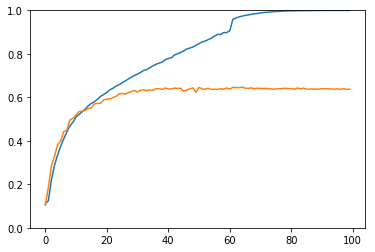

In [5]:
lr = 0.0002
epochs = 100

a = []
b = []
for epoch in range(epochs):
    if epoch > 60:
        lr = 0.0001
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = sce(output, label)
        loss.backward()
        for param in params:
            param[:] = param - lr * param.grad
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    a.append(train_acc/len(train_data))
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("Epoch %d, Loss: %f, Train acc %f, Test acc %f" % (epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()